In [23]:
import os
import cv2
import time
import numpy as np
import pandas as pd
import random
import io
import base64
from IPython.display import HTML

from tensorflow.keras.preprocessing.image import img_to_array, array_to_img
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.applications import imagenet_utils
from imutils.object_detection import non_max_suppression

import matplotlib.pyplot as plt
from tkinter import *
import matplotlib
matplotlib.use('TkAgg')
%matplotlib inline

In [24]:
config = {
    "data_folder": "D:/something-something-project/data/videos/20bn-something-something-v2/",

    "json_data_train": "D:/something-something-project/data/train_data.json",
    "json_data_val": "D:/something-something-project/data/validation_data.json",

    "json_file_labels": "D:/something-something-project/data/something-something-v2-mylabels.json",
}

In [25]:
# load validation data
val_data = pd.read_json(config['json_data_val'], orient="records")
val_data.head()

,id,label,template,placeholders
0,107014,dropping a card in front of a coin,Dropping [something],"[a card, a coin]"
1,57049,dropping something into something,Dropping [something],"[something, something]"
2,28209,dropping something onto something,Dropping [something],"[something, something]"
3,43315,dropping a flip flop behind a box of origami c...,Dropping [something],"[a flip flop, a box of origami cranes]"
4,216970,dropping a comb into a box,Dropping [something],"[a comb, a box]"


In [26]:
val_data.shape

(3217, 4)

In [45]:
val_ids = val_data["id"].tolist()
selected_index = random.choice(val_ids)
selected_row = val_data.loc[val_data['id'] == selected_index]

In [46]:
print ("id: ", selected_row["id"].tolist()[0])
print ("Label: ", selected_row["template"].tolist()[0])
print ("Object: ", selected_row["placeholders"].tolist()[0])

id:  123531
Label:  Poking [something]
Object:  ['bus ticket']


In [47]:
path_to_vid = os.path.join(config["data_folder"], str(selected_index) + ".webm")
print (path_to_vid)

D:/something-something-project/data/videos/20bn-something-something-v2/123531.webm


In [48]:
video = io.open(path_to_vid, 'r+b').read()
encoded = base64.b64encode(video)
HTML(data='''<video alt="test" controls>
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii')))

In [39]:
class DictX(dict):
    def __getattr__(self, key):
        try:
            return self[key]
        except KeyError as k:
            raise AttributeError(k)

    def __setattr__(self, key, value):
        self[key] = value

    def __delattr__(self, key):
        try:
            del self[key]
        except KeyError as k:
            raise AttributeError(k)

    def __repr__(self):
        return '<DictX ' + dict.__repr__(self) + '>'


def selective_search(image, method="fast"):
    # initialize OpenCV's selective search implementation and set the input image
    ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()
    ss.setBaseImage(image)
    
    # check to see if we are using "fast" but "less accurate" version of selective search
    if method == "fast":
        ss.switchToSelectiveSearchFast()
        
    # otherwise we are using "slower" but "more accurate" version
    else:
        ss.switchToSelectiveSearchQuality()
        
    # run selective search on the input image
    rects = ss.process()
    
    # return the region proposal bounding boxes
    return rects

In [40]:
args = DictX ({
    "image": "./beagle.png", # location of image
    "method": "fast",          # ["fast", "slow"]
    "conf": "0.9",             # minimum probabilty to consider a classification/detection
    "filter": "biscuit"             # comma separated list of ImageNet labels to filter on
})

# grab label filters
labelFilters = args.filter

# if the label filter is not empty, break it into a list
if labelFilters is not None:
    labelFilters = labelFilters.lower().split(",")
    
# load ResNet (with weights pre-trained on ImageNet)
print ("Loading ResNet...")
model = ResNet50(weights="imagenet")

Loading ResNet...


performing selective search with 'fast' method
166 regions found by selective search
Proposal shape: (68, 224, 224, 3)
Classifying proposals...
[INFO] showing results for 'rule'
[0.9251666  0.95652765 0.9268363  0.94961935 0.9525375  0.92373925
 0.93745655 0.91525364]
[[ 60  35 112 193]]


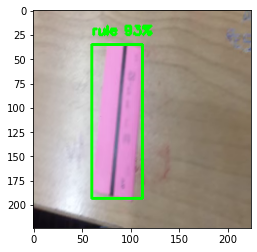

[INFO] cleaning up...


In [49]:
vs = cv2.VideoCapture(path_to_vid)
(W, H) = (None, None)

frame_rate = 1
prev = 0

# loop over frames from the video file stream
while True:
    time_elapsed = time.time() - prev
    
    if time_elapsed <= 1./frame_rate:
        break
    
    prev = time.time()
    
    # read the next frame from the file
    (grabbed, frame) = vs.read()

    # if the frame was not grabbed, then we have reached the end
    # of the stream
    if not grabbed:
        print ("breaking")
        break

    # if the frame dimensions are empty, grab them
    if W is None or H is None:
        (H, W) = frame.shape[:2]

    # clone the output frame, then convert it from BGR to RGB
    # ordering, resize the frame to a fixed 224x224, and then
    # perform mean subtraction
    output = frame.copy()
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    frame = cv2.resize(frame, (224, 224))
    
    print ("performing selective search with '{}' method".format(args.method))
    rects = selective_search(frame, method=args.method)
    print ("{} regions found by selective search".format(len(rects)))

    # initialize the list of region proposals that we'll be classifying
    # along with their associated bounding boxes
    proposals = []
    boxes = []
    
    # loop over the region proposal bounding box coordinates generated by
    # running selective search
    for (x, y, w, h) in rects:
        # if the width or height of the region is less than 10% of the
        # image width or height, ignore it (i.e., filter out small
        # objects that are likely false-positives)
        if w/float(W) < 0.1 or h/float(H) < 0.1:
            continue

        # extract the region from the input image, convert it from BGR to
        # RGB channel ordering, and them resize it to 224x224 (the input
        # dimesnsion required by our pretrained CNN)
        roi = frame[y:y+h, x:x+w]
        roi = cv2.cvtColor(roi, cv2.COLOR_BGR2RGB)
        roi = cv2.resize(roi, (224, 224))

        # further processing by the ROI
        roi = img_to_array(roi)
        roi = preprocess_input(roi)

        # update our proposals and bounding boxes lists
        proposals.append(roi)
        boxes.append((x, y, w, h))
        
    # convert the proposals list into numpy array and show its dimensions
    proposals = np.array(proposals)
    print ("Proposal shape: {}".format(proposals.shape))

    # classify each of the proposal ROIs using ResNet and then decode the
    # predictions
    print ("Classifying proposals...")
    preds = model.predict(proposals)
    preds = imagenet_utils.decode_predictions(preds, top=1)

    # initialize a dictionary which maps class labels (keys) to any
    # bounding box associated with that label (values)
    labels = {}
    
    # loop over the predictions
    for (i, p) in enumerate(preds):
        # grab the prediction information for the current region proposal
        (imagenetID, label, prob) = p[0]

        # only if the label filters are not empty "and" the label does not
        # exist in the list, then ignore it

        # try to look for label which we are interested in, else find the label with highest probability
    #     if labelFilters is not None and label not in labelFilters:
    #         continue

        # filter out weak detections by ensuring the predicted probability
        # is greater than the minimum probability
        if prob >= float(args.conf):
            # grab the bounding box associated with the prediction and
            # convert the coordinates
            (x, y, w, h) = boxes[i]
            box = (x, y, x + w, y + h)

            # grab the list of predictions for the label and add the
            # bounding box + probability to the list
            L = labels.get(label, [])
            L.append((box, prob))
            labels[label] = L
            
    image_frames = []

    for label in labels.keys():
        print("[INFO] showing results for '{}'".format(label))
        clone = frame.copy()
        # extract the bounding boxes and associated prediction
        # probabilities, then apply non-maxima suppression
        boxes = np.array([p[0] for p in labels[label]])
        proba = np.array([p[1] for p in labels[label]])
        boxes = non_max_suppression(boxes, proba)
        # loop over all bounding boxes that were kept after applying
        # non-maxima suppression
        print (proba)
        print (boxes)
        for (startX, startY, endX, endY), prob in zip(boxes, proba):
            # draw the bounding box and label on the image
            cv2.rectangle(clone, (startX, startY), (endX, endY),
                (0, 255, 0), 2)
            y = startY - 10 if startY - 10 > 10 else startY + 10
            cv2.putText(clone, label + " {0:.0%}".format(prob), (startX, y),
                cv2.FONT_HERSHEY_SIMPLEX, 0.45, (0, 255, 0), 2)

        image_frames.append(clone)
        # show the output after apply non-maxima suppression
        # cv2.imshow("After", clone)
        # cv2.waitKey(0)
    #     plt.imshow(clone)
    # plt.show(block=True)
    
    for img in image_frames:
        plt.figure()
        plt.imshow(array_to_img(img))
        plt.show()

print("[INFO] cleaning up...")

In [2]:
import io
from matplotlib.backends.backend_agg import FigureCanvasAgg
from matplotlib.backends.backend_svg import FigureCanvasSVG
from matplotlib.figure import Figure
import matplotlib.pyplot as plt
import cv2

In [4]:
img = cv2.imread("./stingray.jpg")

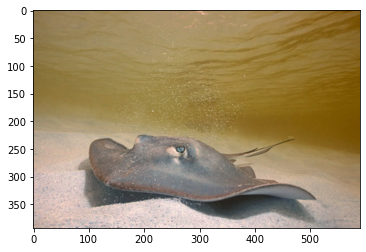

In [5]:
fig = Figure()
plt.imshow(img)

<Figure size 432x288 with 0 Axes>